# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [9]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/neha/mlfs-book
HopsworksSettings initialized!


In [10]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [11]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 21, 31, 18, 700573)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [12]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 21:31:18,717 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 21:31:18,735 INFO: Initializing external client
2025-11-18 21:31:18,735 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 21:31:19,445 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 21:31:20,675 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1295508


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [13]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 21:31:25,910 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/540733 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114947 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/16927 elapsed<00:00 remaining<?

In [14]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4664879E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [15]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-20 00:00:00+00:00,0.90,0.0,11.874544,14.036275,Stockholm
1,2025-11-19 00:00:00+00:00,-0.45,0.1,5.014219,338.962402,Stockholm
2,2025-11-21 00:00:00+00:00,-1.65,0.0,8.788720,304.992096,Stockholm
3,2025-11-22 00:00:00+00:00,1.65,0.0,19.296135,216.656204,Stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [16]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
  batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-20 00:00:00+00:00,0.90,0.0,11.874544,14.036275,Stockholm,22.387873
1,2025-11-19 00:00:00+00:00,-0.45,0.1,5.014219,338.962402,Stockholm,28.869244
2,2025-11-21 00:00:00+00:00,-1.65,0.0,8.788720,304.992096,Stockholm,45.760239
3,2025-11-22 00:00:00+00:00,1.65,0.0,19.296135,216.656204,Stockholm,28.237625


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         4 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          4 non-null      float32                
 2   precipitation_sum            4 non-null      float32                
 3   wind_speed_10m_max           4 non-null      float32                
 4   wind_direction_10m_dominant  4 non-null      float32                
 5   city                         4 non-null      object                 
 6   predicted_pm25               4 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 272.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-19 00:00:00+00:00,-0.45,0.1,5.014219,338.962402,Stockholm,28.869244,St-Eriksgatan-83,Sweden,2
0,2025-11-20 00:00:00+00:00,0.90,0.0,11.874544,14.036275,Stockholm,22.387873,St-Eriksgatan-83,Sweden,1
2,2025-11-21 00:00:00+00:00,-1.65,0.0,8.788720,304.992096,Stockholm,45.760239,St-Eriksgatan-83,Sweden,3
3,2025-11-22 00:00:00+00:00,1.65,0.0,19.296135,216.656204,Stockholm,28.237625,St-Eriksgatan-83,Sweden,4


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         4 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          4 non-null      float32                
 2   precipitation_sum            4 non-null      float32                
 3   wind_speed_10m_max           4 non-null      float32                
 4   wind_direction_10m_dominant  4 non-null      float32                
 5   city                         4 non-null      object                 
 6   predicted_pm25               4 non-null      float32                
 7   street                       4 non-null      object                 
 8   country                      4 non-null      object                 
 9   days_before_forecast_day     4 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 21:31:34,423 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



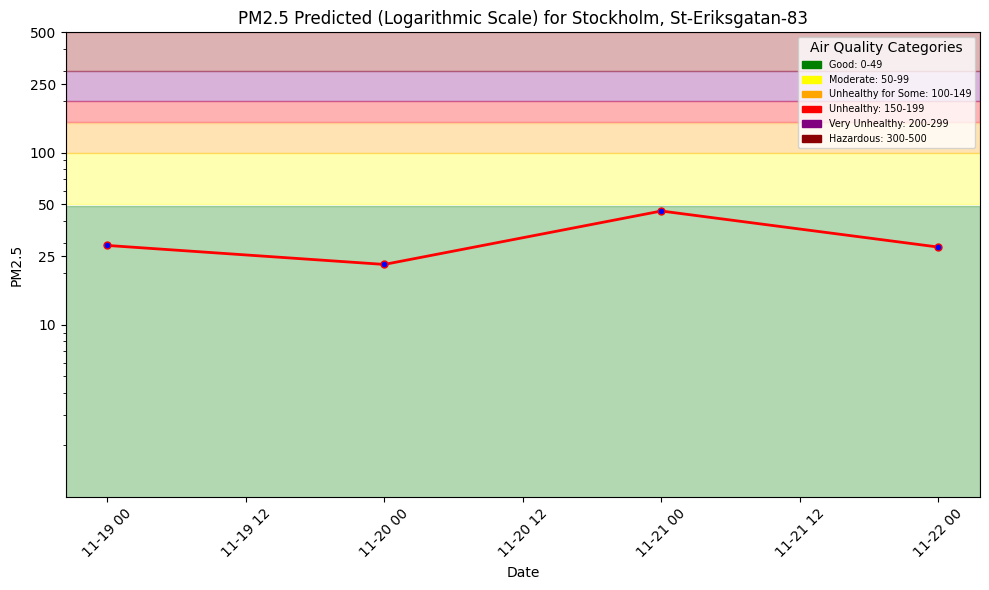

In [20]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [21]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [22]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1295508/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 21:31:52,173 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 21:31:55,357 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 21:33:24,837 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 21:33:25,007 INFO: Waiting for log aggregation to finish.
2025-11-18 21:33:37,051 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [23]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.71s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,0.900000,0.0,11.874544,14.036275,Stockholm,22.387873,St-Eriksgatan-83,Sweden,1
1,2025-11-16 00:00:00+00:00,2.600000,0.0,11.019764,231.632477,Stockholm,29.196667,St-Eriksgatan-83,Sweden,1
2,2025-11-13 00:00:00+00:00,7.041166,3.9,20.707041,267.233887,Stockholm,10.609777,St-Eriksgatan-83,Sweden,1
3,2025-11-15 00:00:00+00:00,-0.152583,0.0,20.316889,268.670654,Stockholm,14.898931,St-Eriksgatan-83,Sweden,1
4,2025-11-14 00:00:00+00:00,1.001583,0.0,16.800856,291.999786,Stockholm,21.065628,St-Eriksgatan-83,Sweden,1


In [24]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,date,pm25,country,city,street,url
0,2019-07-24 00:00:00+00:00,13.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10009
1,2022-11-28 00:00:00+00:00,34.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10009
2,2020-03-05 00:00:00+00:00,11.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10009
3,2025-01-12 00:00:00+00:00,7.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10009
4,2019-07-03 00:00:00+00:00,12.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10009
...,...,...,...,...,...,...
5292,2022-07-24 00:00:00+00:00,11.0,Sweden,Stockholm,St-Eriksgatan-83,https://api.waqi.info/feed/@10523
5293,2022-07-25 00:00:00+00:00,24.0,Sweden,Stockholm,St-Eriksgatan-83,https://api.waqi.info/feed/@10523
5294,2021-09-04 00:00:00+00:00,10.0,Sweden,Stockholm,St-Eriksgatan-83,https://api.waqi.info/feed/@10523
5295,2023-11-14 00:00:00+00:00,10.0,Sweden,Stockholm,St-Eriksgatan-83,https://api.waqi.info/feed/@10523


In [25]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2025-11-13 00:00:00+00:00,10.609777,9.0
3,2025-11-14 00:00:00+00:00,21.065628,13.0
2,2025-11-15 00:00:00+00:00,14.898931,11.0
0,2025-11-16 00:00:00+00:00,29.196667,14.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

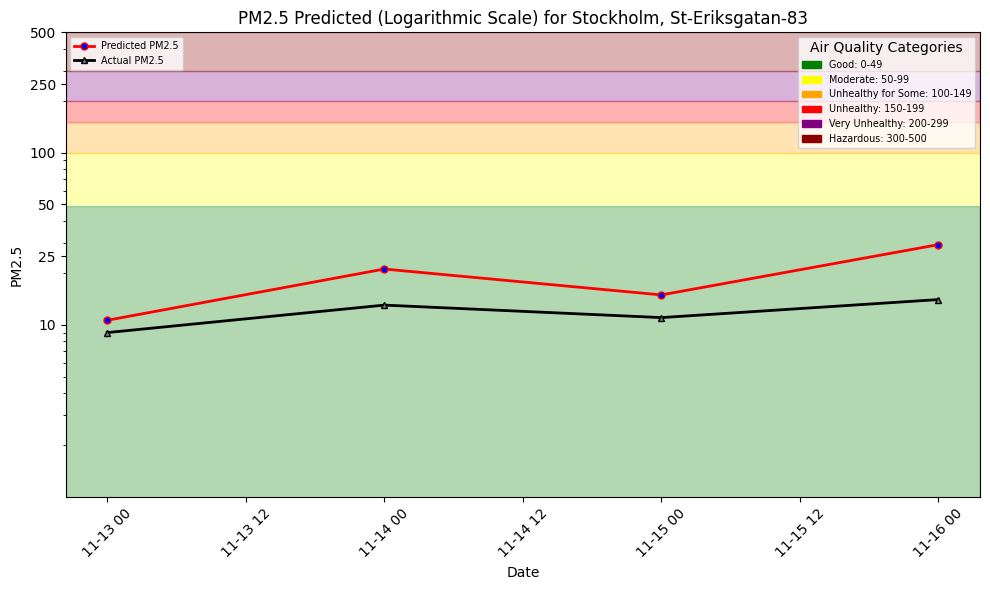

In [26]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [27]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/neha/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/43208 elap…

Uploading /Users/neha/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/47058…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1295508/settings/fb/path/Resources/airquality


---